In [113]:
import pandas as pd
import scipy.stats
import math
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools as smt


%matplotlib inline

In [21]:
data = pd.read_csv('shot_logs.csv')
data.head(2)

,GAME_ID,MATCHUP,LOCATION,WIN_LOSE,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148


In [30]:
print(data['SHOT_CLOCK'].max(), data['SHOT_CLOCK'].min())

24.0 0.0


In [51]:
def prepareDF(df):
    # Create location, win_lose dummy variable
    df = df.join(pd.get_dummies(df[['LOCATION','WIN_LOSE']]))
    
    # replace GAME_CLOCK with seconds 
    GAME_CLOCK1 = []
    for i in df['GAME_CLOCK']:
        a = i.split(':')
        #b = (int(a[0])*60 + int(a[1]))/720
        b = (float(a[0])*60 + float(a[1]))
        GAME_CLOCK1.append(b)
    df['GAME_CLOCK'] = GAME_CLOCK1
    
    #fill empty shot clocl with game clock values 
    df['SHOT_CLOCK'] = df['SHOT_CLOCK'].fillna(value=df['GAME_CLOCK'])
    df=df.drop(data[data.SHOT_CLOCK > 24].index)
    #data['SHOT_CLOCK'].max()
    
    # normalize numerica variable
    numeric_col=['GAME_CLOCK','FINAL_MARGIN','SHOT_NUMBER','PERIOD','SHOT_CLOCK','DRIBBLES','TOUCH_TIME','SHOT_DIST','PTS_TYPE','CLOSE_DEF_DIST','FGM','PTS']
    x = df[numeric_col].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df[numeric_col] = pd.DataFrame(x_scaled)
    
    df = df.dropna(axis=0)
    
    col_list = list(df)
    remove_list = ['GAME_ID', 'MATCHUP', 'LOCATION', 'WIN_LOSE', 'SHOT_RESULT', 
                   'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name', 
                   'player_id', 'LOCATION_A', 'WIN_LOSE_L', 'PTS']
    for remove_item in remove_list:
        col_list.remove(remove_item)
    
    train_data = df.loc[:, col_list]

    return train_data

In [73]:
df = prepareDF(data)

sample_index = random.sample(range(len(df)), int(len(df)*0.8))
train = df.iloc[sample_index]
test = df.iloc[[i for i in range(len(df)) if i not in sample_index]]

#### We use 'SHOT_CLOCK' as our continuous outcome variable

In [74]:
def prepareXY(train, test):
    train_Y = train['SHOT_CLOCK']
    train_X = train.drop(['SHOT_CLOCK'], axis=1)
    test_Y = test['SHOT_CLOCK']
    test_X = test.drop(['SHOT_CLOCK'], axis=1)
    return train_Y, train_X, test_Y, test_X


In [75]:
train_Y, train_X, test_Y, test_X = prepareXY(train, test)

In [76]:
train_Y.mean()*24

0.6020304008501698

In [80]:
train_X.cov()

,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,LOCATION_H,WIN_LOSE_W
FINAL_MARGIN,1.560053e-02,-6.213317e-07,-0.000074,0.000243,0.000171,0.000026,0.000251,0.001519,0.000214,0.003702,0.009703,0.050559
SHOT_NUMBER,-6.213317e-07,1.629970e-02,0.015908,-0.008647,0.001938,0.000295,0.000252,0.000119,-0.000249,-0.000550,-0.000421,-0.000345
PERIOD,-7.382483e-05,1.590843e-02,0.036075,-0.001454,0.001116,0.000137,0.001017,0.003972,-0.000092,-0.001306,-0.000035,-0.000840
GAME_CLOCK,2.426414e-04,-8.646811e-03,-0.001454,0.083092,-0.003646,-0.000479,-0.001180,-0.006337,0.000105,0.001547,0.000150,0.002108
DRIBBLES,1.705551e-04,1.937817e-03,0.001116,-0.003646,0.011776,0.001599,-0.001687,-0.008071,-0.000861,-0.001850,-0.000767,0.000745
TOUCH_TIME,2.557205e-05,2.945036e-04,0.000137,-0.000479,0.001599,0.000252,-0.000253,-0.001281,-0.000137,-0.000373,-0.000096,0.000128
SHOT_DIST,2.507628e-04,2.524619e-04,0.001017,-0.001180,-0.001687,-0.000253,0.035471,0.061511,0.005078,-0.018038,-0.000127,0.000640
PTS_TYPE,1.519304e-03,1.189003e-04,0.003972,-0.006337,-0.008071,-0.001281,0.061511,0.194379,0.009411,-0.026767,0.000911,0.003756
CLOSE_DEF_DIST,2.136671e-04,-2.494851e-04,-0.000092,0.000105,-0.000861,-0.000137,0.005078,0.009411,0.002677,-0.000026,0.000078,0.000729
FGM,3.701650e-03,-5.496972e-04,-0.001306,0.001547,-0.001850,-0.000373,-0.018038,-0.026767,-0.000026,0.247770,0.002534,0.012344


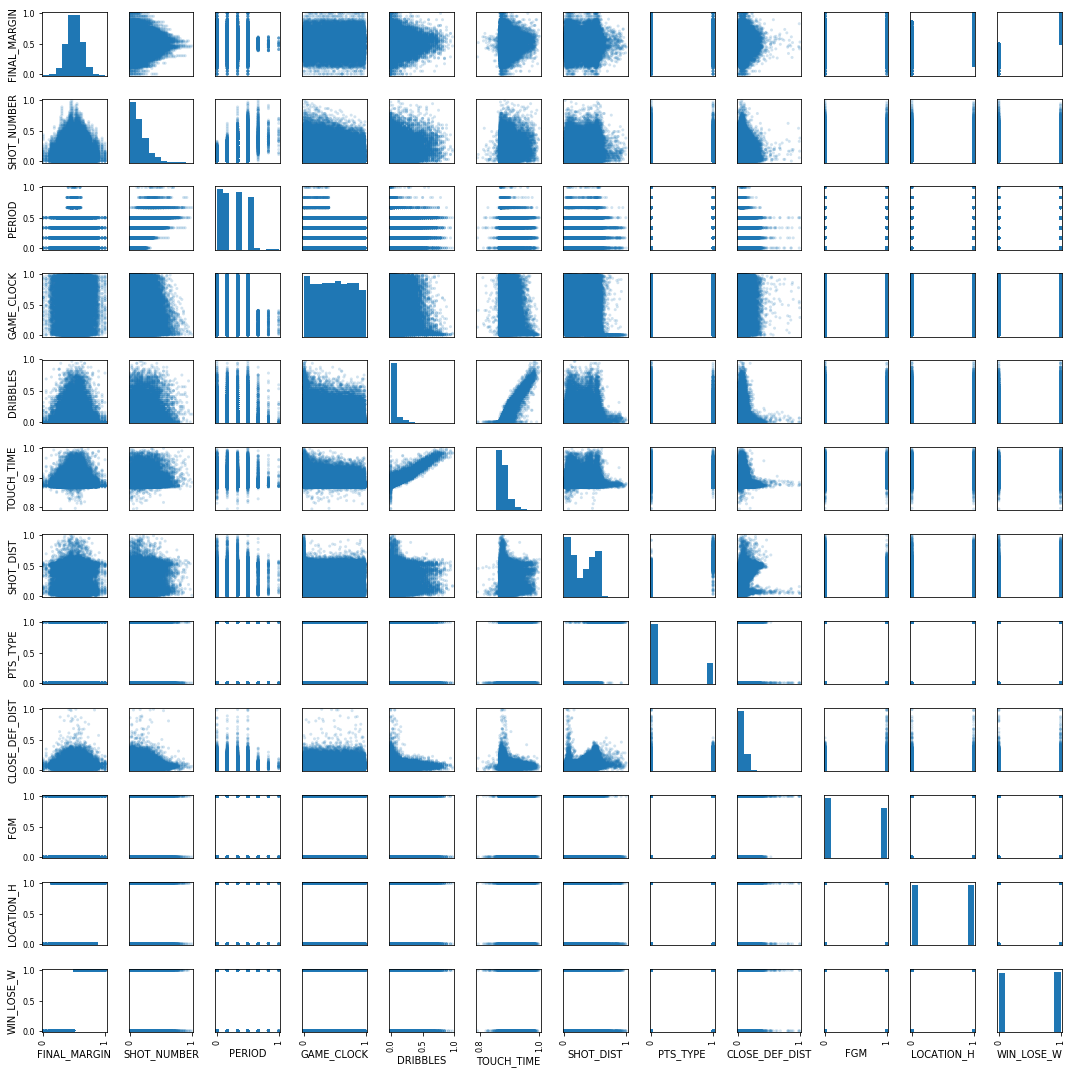

In [90]:
pd.plotting.scatter_matrix(train_X, alpha=0.2, figsize=(15,15))
plt.tight_layout() 

#### Baseline Model

In [82]:
lin_results = smf.ols('SHOT_CLOCK ~ '+'+'.join(list(set(train_data.columns)-{'SHOT_CLOCK'})), data = train).fit()
print(lin_results.summary())

                            OLS Regression Results                            
Dep. Variable:             SHOT_CLOCK   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     75.42
Date:                Tue, 30 Apr 2019   Prob (F-statistic):          3.23e-185
Time:                        23:01:34   Log-Likelihood:             1.2414e+05
No. Observations:              102455   AIC:                        -2.483e+05
Df Residuals:                  102442   BIC:                        -2.481e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1907      0.034      5.

In [83]:
lin_results.predict().mean()*(data['SHOT_CLOCK'].max() - data['SHOT_CLOCK'].min()) + data['SHOT_CLOCK'].min()

0.6020304008502424

In [118]:
smt.eval_measures.rmse(test_Y, lin_results.predict(test_X), axis=0)

0.07415323861210163

In [88]:
rsq_in = smf.ols('SHOT_CLOCK ~ '+'+'.join(list(set(train.columns)-{'SHOT_CLOCK'})), data = train).fit().rsquared
print("The in-sample r-squared is", rsq_in)

The in-sample r-squared is 0.008757823910879425


In [86]:
scores = cross_val_score(LinearRegression(), train_X, train_Y, cv=5, scoring='r2')
print("Linear Regression: 5-fold Cross-Validation: R-squared: %f" % (scores.mean()))

Linear Regression: 5-fold Cross-Validation: R-squared: 0.008298


In [93]:
lm = smf.ols('SHOT_CLOCK ~ '+'+'.join(list(set(train.columns)-{'SHOT_CLOCK'})), data=train).fit()
rsq_out = 1. - np.sum((lm.predict(test_X)-test['SHOT_CLOCK'])**2)/np.sum((test['SHOT_CLOCK'].mean()-test['SHOT_CLOCK'])**2)
print("The out-of-sample r-squared is", rsq_out)

The out-of-sample r-squared is 0.011094577585849308


#### Linear Model with a few Covariates

In [122]:
lin_c = smf.ols('SHOT_CLOCK ~ PERIOD+GAME_CLOCK+DRIBBLES+TOUCH_TIME+CLOSE_DEF_DIST+FGM', data = train).fit()
print('MSE:',smt.eval_measures.rmse(test_Y, lin_c.predict(test_X), axis=0))
print("The in-sample r-squared is", lin_c.rsquared)

MSE: 0.07417042975800428
The in-sample r-squared is 0.008185512269377915


#### Two way linear regression

In [91]:
import itertools
rsq_in_2 = smf.ols('SHOT_CLOCK ~ '+' + '.join(list(set(train.columns)-{'SHOT_CLOCK'})+['%s:%s'%v for v in itertools.combinations(set(train.columns)-{'SHOT_CLOCK'},2)]), data=train).fit().rsquared
print("The two-way in-sample r-squared is", rsq_in_2)

The two-way in-sample r-squared is 0.012439274785531418


In [92]:
lm_2 = smf.ols('SHOT_CLOCK ~ '+' + '.join(list(set(train.columns)-{'SHOT_CLOCK'})+['%s:%s'%v for v in itertools.combinations(set(train.columns)-{'SHOT_CLOCK'},2)]), data=train).fit()
rsq_out_2 = 1. - np.sum((lm_2.predict(test_X)-test['SHOT_CLOCK'])**2)/np.sum((test['SHOT_CLOCK'].mean()-test['SHOT_CLOCK'])**2)
print("The out-of-sample r-squared is", rsq_out_2)

The out-of-sample r-squared is 0.01001485243364253


In [123]:
smt.eval_measures.rmse(test_Y, lm_2.predict(test_X), axis=0)

0.07419370925388821

#### Stepwise Regression - Best Model

In [94]:
def fitmodel(S,data):
    return smf.ols('SHOT_CLOCK ~ '+('+'.join(S) if len(S)>0 else '1'), data=train).fit()

In [95]:
singlefeatures = list(set(train.columns)-{'SHOT_CLOCK'})
interactions = ['%s:%s'%v for v in itertools.combinations(singlefeatures,2)]
len(interactions)+len(singlefeatures)

78

In [96]:
## forward stepwise
Sfwd = set()
features = set(singlefeatures).union(set(interactions))
while len(Sfwd) < len(features):
    f = max(features - Sfwd, key = lambda f: -fitmodel(Sfwd.union({f}),train).aic)
    after = -fitmodel(Sfwd.union({f}),train).aic
    before = -fitmodel(Sfwd,train).aic
    #print(after, before)
    if after > before:
        Sfwd = Sfwd.union({f})
    else:
        break
print(Sfwd)
    

{'SHOT_DIST:WIN_LOSE_W', 'SHOT_DIST:LOCATION_H', 'WIN_LOSE_W:TOUCH_TIME', 'GAME_CLOCK:PERIOD', 'LOCATION_H', 'LOCATION_H:GAME_CLOCK', 'WIN_LOSE_W:PERIOD', 'SHOT_DIST:TOUCH_TIME', 'DRIBBLES:PERIOD', 'WIN_LOSE_W:DRIBBLES', 'LOCATION_H:PTS_TYPE', 'PTS_TYPE:GAME_CLOCK', 'LOCATION_H:TOUCH_TIME', 'FINAL_MARGIN', 'SHOT_DIST', 'FGM:PERIOD', 'SHOT_NUMBER:SHOT_DIST', 'WIN_LOSE_W', 'CLOSE_DEF_DIST:LOCATION_H', 'FINAL_MARGIN:WIN_LOSE_W', 'TOUCH_TIME', 'GAME_CLOCK', 'SHOT_NUMBER:GAME_CLOCK', 'TOUCH_TIME:DRIBBLES', 'LOCATION_H:WIN_LOSE_W'}


In [97]:
## backward stepwise
features = set(singlefeatures).union(set(interactions))
Sbwd = set(features)
while len(Sbwd)>0:
    f = max(Sbwd, key = lambda f: -fitmodel(Sbwd-{f},train).aic)
    after = -fitmodel(Sbwd-{f},train).aic
    before = -fitmodel(Sbwd,train).aic
    if after > before:
        Sbwd = Sbwd-{f}
    else:
        break

display(len(Sbwd))
print(Sbwd)


34

{'SHOT_DIST:LOCATION_H', 'WIN_LOSE_W:TOUCH_TIME', 'DRIBBLES:FGM', 'DRIBBLES:PERIOD', 'LOCATION_H:PERIOD', 'WIN_LOSE_W:DRIBBLES', 'LOCATION_H:PTS_TYPE', 'LOCATION_H:DRIBBLES', 'FINAL_MARGIN:SHOT_DIST', 'TOUCH_TIME:FGM', 'LOCATION_H:TOUCH_TIME', 'SHOT_DIST', 'WIN_LOSE_W', 'SHOT_NUMBER:LOCATION_H', 'SHOT_DIST:GAME_CLOCK', 'SHOT_NUMBER:PTS_TYPE', 'TOUCH_TIME', 'GAME_CLOCK', 'FGM', 'CLOSE_DEF_DIST:GAME_CLOCK', 'LOCATION_H', 'SHOT_DIST:TOUCH_TIME', 'WIN_LOSE_W:PERIOD', 'CLOSE_DEF_DIST:SHOT_DIST', 'LOCATION_H:FGM', 'FINAL_MARGIN:TOUCH_TIME', 'FGM:PERIOD', 'SHOT_NUMBER:GAME_CLOCK', 'SHOT_DIST:FGM', 'FINAL_MARGIN:WIN_LOSE_W', 'CLOSE_DEF_DIST:LOCATION_H', 'CLOSE_DEF_DIST:FGM', 'GAME_CLOCK:PERIOD', 'LOCATION_H:WIN_LOSE_W'}


In [98]:
## stepwise
Sboth = Sfwd if -fitmodel(Sfwd,train).aic > -fitmodel(Sbwd,train).aic else Sbwd
display(len(Sboth))
print('The model contains the following variables:', Sboth)

25

The model contains the following variables: {'SHOT_DIST:WIN_LOSE_W', 'SHOT_DIST:LOCATION_H', 'WIN_LOSE_W:TOUCH_TIME', 'GAME_CLOCK:PERIOD', 'LOCATION_H', 'LOCATION_H:GAME_CLOCK', 'WIN_LOSE_W:PERIOD', 'SHOT_DIST:TOUCH_TIME', 'DRIBBLES:PERIOD', 'WIN_LOSE_W:DRIBBLES', 'LOCATION_H:PTS_TYPE', 'PTS_TYPE:GAME_CLOCK', 'LOCATION_H:TOUCH_TIME', 'FINAL_MARGIN', 'SHOT_DIST', 'FGM:PERIOD', 'SHOT_NUMBER:SHOT_DIST', 'WIN_LOSE_W', 'CLOSE_DEF_DIST:LOCATION_H', 'FINAL_MARGIN:WIN_LOSE_W', 'TOUCH_TIME', 'GAME_CLOCK', 'SHOT_NUMBER:GAME_CLOCK', 'TOUCH_TIME:DRIBBLES', 'LOCATION_H:WIN_LOSE_W'}


In [99]:
print(fitmodel(Sfwd,train).aic)
print(fitmodel(Sbwd,train).aic)
print(fitmodel(Sboth,train).aic)

-248575.59749144386
-248574.27768363128
-248575.59749144386


In [106]:
lm_step = smf.ols('SHOT_CLOCK ~ '+' + '.join(list(Sboth)), data=train).fit()
rsq_in_step = lm_step.rsquared
rsq_out_step = 1. - np.sum((lm_step.predict(test_X)-test['SHOT_CLOCK'])**2)/np.sum((test['SHOT_CLOCK'].mean()-test['SHOT_CLOCK'])**2)

print('In-sample:', rsq_in_step)
print('Out-of-sample:', rsq_out_step)


In-sample: 0.012096587549351279
Out-of-sample: 0.01322573556605211


In [124]:
smt.eval_measures.rmse(test_Y, lm_step.predict(test_X), axis=0)

0.07407329289784931

In [172]:
lm_step_coef_df.columns[sorted_idx]

IndexError: index 10 is out of bounds for axis 1 with size 1

array(['SHOT_DIST:WIN_LOSE_W', 'SHOT_DIST:LOCATION_H',
       'WIN_LOSE_W:TOUCH_TIME', 'GAME_CLOCK:PERIOD', 'LOCATION_H',
       'LOCATION_H:GAME_CLOCK', 'WIN_LOSE_W:PERIOD',
       'SHOT_DIST:TOUCH_TIME', 'DRIBBLES:PERIOD', 'WIN_LOSE_W:DRIBBLES',
       'LOCATION_H:PTS_TYPE', 'PTS_TYPE:GAME_CLOCK',
       'LOCATION_H:TOUCH_TIME', 'FINAL_MARGIN', 'SHOT_DIST', 'FGM:PERIOD',
       'SHOT_NUMBER:SHOT_DIST', 'WIN_LOSE_W', 'CLOSE_DEF_DIST:LOCATION_H',
       'FINAL_MARGIN:WIN_LOSE_W', 'TOUCH_TIME', 'GAME_CLOCK',
       'SHOT_NUMBER:GAME_CLOCK', 'TOUCH_TIME:DRIBBLES',
       'LOCATION_H:WIN_LOSE_W'], dtype=object)

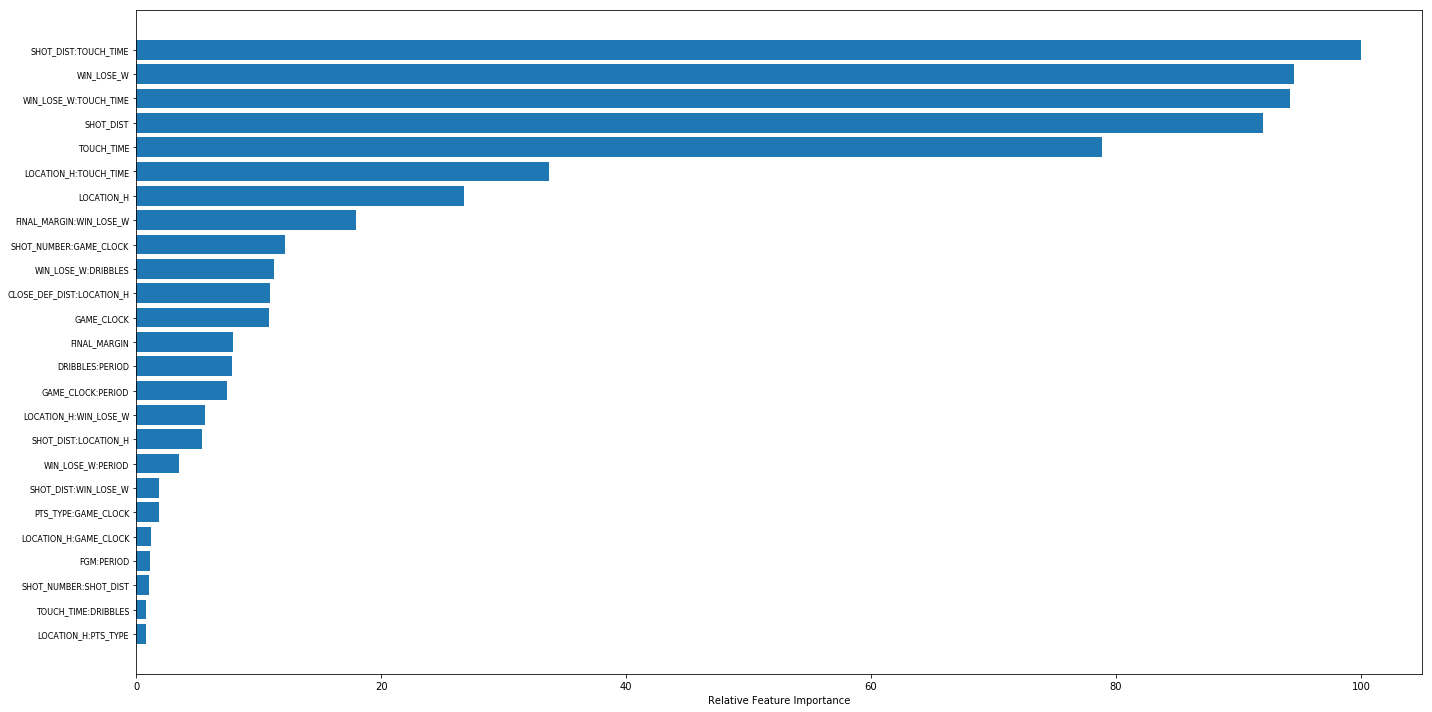

In [176]:
lm_step_coef = dict(abs(lm_step.params[1:]))
lm_step_coef_df = pd.DataFrame.from_dict(lm_step_coef, orient='index', columns = ['coef'])

feature_importance = lm_step_coef_df['coef']
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=[20, 10])
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(lm_step_coef_df.index.values[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### LASSO

In [101]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
x = poly.fit_transform(train_X)
x_test = poly.fit_transform(test_X)

In [102]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5, random_state=0).fit(x, train_Y)

/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

In [127]:
print('This model contains the following variables:')
for i in range(len((interactions))):
    if lasso.coef_[i] != 0:
        print(interactions[i],":", lasso.coef_[i])

This model contains the following variables:
CLOSE_DEF_DIST:SHOT_NUMBER : 0.017840878108813844
CLOSE_DEF_DIST:LOCATION_H : 0.0217540351624249
CLOSE_DEF_DIST:TOUCH_TIME : -0.1301822734984287
CLOSE_DEF_DIST:PTS_TYPE : -0.010768706814630088
CLOSE_DEF_DIST:GAME_CLOCK : -3.22134582054476e-05
CLOSE_DEF_DIST:DRIBBLES : 0.00010810250374995741
CLOSE_DEF_DIST:FGM : 0.00019248482967680687
CLOSE_DEF_DIST:PERIOD : 0.005377962135205143
SHOT_NUMBER:FINAL_MARGIN : 0.01732189252401845
SHOT_NUMBER:DRIBBLES : 0.0010422885341261829
SHOT_NUMBER:PERIOD : -0.0026635213469699127
FINAL_MARGIN:SHOT_DIST : -0.00475925028912309
FINAL_MARGIN:LOCATION_H : -0.03403820923267398
FINAL_MARGIN:WIN_LOSE_W : 0.009650102731639815
FINAL_MARGIN:TOUCH_TIME : -0.021138831269989892
FINAL_MARGIN:GAME_CLOCK : -0.005552283348700311
FINAL_MARGIN:FGM : 0.0032624756187095458
SHOT_DIST:WIN_LOSE_W : -0.004189368329886425
SHOT_DIST:TOUCH_TIME : 0.0003895404399591518
SHOT_DIST:PTS_TYPE : -0.016618561832117733
SHOT_DIST:GAME_CLOCK : 0.010

In [104]:
print(((lasso.predict(x_test)-test_Y)**2).mean())

0.005487380581216039


In [109]:
scores_laxsso = cross_val_score(LassoCV(), train_X, train_Y, cv=5, scoring='r2')
print("Linear Regression: 5-fold Cross-Validation: R-squared: %f" % (scores.mean()))

/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yuekunwang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify 

Linear Regression: 5-fold Cross-Validation: R-squared: 0.008298
